## Scott Breitbach
### DSC530: Week 10
### Assignment 10.2
### 04-November-2020

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [2]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])

In [3]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

In [4]:
dailies = GroupByQualityAndDay(transactions)

In [5]:
import statsmodels.formula.api as smf

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

In [6]:
def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

def PlotSimplePrediction(results, years):
    predict = GenerateSimplePrediction(results, years)

    thinkplot.Scatter(daily.years, daily.ppg, alpha=0.2, label=name)
    thinkplot.plot(years, predict, color='#ff7f00')
    xlim = years[0]-0.1, years[-1]+0.1
    thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)',
                 loc='upper right')

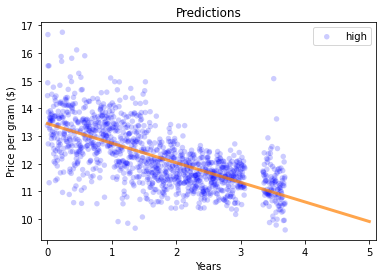

In [7]:
name = 'high'
daily = dailies[name]

_, results = RunLinearModel(daily)
years = np.linspace(0, 5, 101)
PlotSimplePrediction(results, years)

## Exercises

### Exercise 12-1

**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [8]:
daily['years2'] = daily.years**2

In [9]:
def RunQuadraticModel(daily):
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

In [10]:
from IPython.display import display

model, results = RunQuadraticModel(daily)
print(name)
display(results.summary())

high


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Wed, 04 Nov 2020   Prob (F-statistic):          4.57e-164
Time:                        15:30:02   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

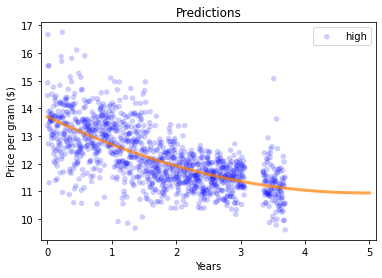

In [11]:
name = 'high'
daily = dailies[name]

_, results = RunQuadraticModel(daily)
years = np.linspace(0, 5, 101)
PlotSimplePrediction(results, years)

In [12]:
def SimulateResults(daily, iters=101, func=RunQuadraticModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

def PlotPredictions(daily, years, iters=101, percent=90, func=RunQuadraticModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

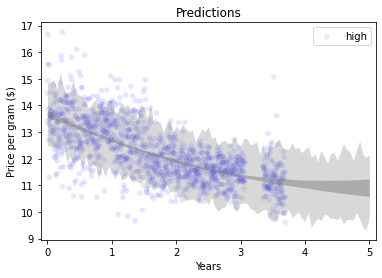

In [13]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                   xlabel='Years',
                   xlim=xlim,
                   ylabel='Price per gram ($)')

### Exercise 12-2

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [14]:
def SerialCorr(series, lag):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [15]:
class SerialCorrelationTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def MakeModel(self):
        pass

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [16]:
def SeriesTest(series):
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    print("Correlation:", test.actual)
    print("P-value:", pvalue)

In [17]:
# Series Correlation of prices:
name = 'high'
daily = dailies[name]
seriesPrice = daily.ppg

SeriesTest(seriesPrice)

Correlation: 0.4852293761947379
P-value: 0.0


In [18]:
# Series Correlation of linear model residuals:
_, results = RunLinearModel(daily)
seriesLinear = results.resid

SeriesTest(seriesLinear)

Correlation: 0.07570473767506261
P-value: 0.005


In [19]:
# Series Correlation of quadratic model residuals:
_, results = RunQuadraticModel(daily)
seriesQuad = results.resid

SeriesTest(seriesQuad)

Correlation: 0.056073081612899194
P-value: 0.053
